# Photometric Analysis
Using the reduced data from leuschner, get differential aperture photometry on your source (or at least one known star) in at least 1 image.  If you can, do this for both B & V and give the B-V color.  Compare this to values from literature.

In [1]:
import sys
myLibPaths = [r'/home/bizard/astronomy/python',
              r'/home/bizard/astronomy/teaching/ASTR 470 - Obs Astro/2021_Spring/coding'
             ]
for libPath in myLibPaths:
    if (libPath not in sys.path):
        sys.path.insert(0,libPath)

In [2]:
import os
import re
import numpy as np
import re

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
from astropy import units as u

from astropy.visualization import (
    hist,
    SqrtStretch,
    LogStretch,
    LinearStretch,
    PercentileInterval,
    AsymmetricPercentileInterval,
    MinMaxInterval,
)
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats

from astropy.nddata import CCDData
from astropy.io import fits

In [5]:
from photutils import (
    DAOStarFinder,
    CircularAperture,
    CircularAnnulus
)

# Define Directory Paths

In [6]:
sciencedir = r'./leuschner/reduced/20210304'

ignore_file = re.compile('(median|average|ignore|test|focus)')
bias_pat = re.compile('[bB]ias_[0-9]{1,2}.fits')
dark_pat = re.compile('[dD]ark_([0-9]{1,3})s_[0-9]{1,2}(_debiased.fits|.fits)')
flat_pat = re.compile('[fF]lat_([UBVRIubvri]{1})_[0-9]{1,2}.fits')

# The science files are all of the ones we aren't ignoring *and* 
# aren't one of the calibration files.
#
science_files = [os.path.join(sciencedir,f) for f in os.listdir(sciencedir) if 
                 (f.endswith('.fits') and 
                  (not ignore_file.search(f)) and
                  (not bias_pat.search(f)) and
                  (not dark_pat.search(f)) and
                  (not flat_pat.search(f))
                 ) ]

In [7]:
science_files

['./leuschner/reduced/20210304/BD+25604_V_10s.fits',
 './leuschner/reduced/20210304/HD23339_V_10s.fits',
 './leuschner/reduced/20210304/SAO56175_B_10s.fits',
 './leuschner/reduced/20210304/HD278265_B_10s.fits',
 './leuschner/reduced/20210304/TYC288725561_V_20s.fits',
 './leuschner/reduced/20210304/VMM_Per_V_20s.fits',
 './leuschner/reduced/20210304/BD+25604_B_30s.fits',
 './leuschner/reduced/20210304/BD+51811_V_10s.fits',
 './leuschner/reduced/20210304/SAO56175_V_10s.fits',
 './leuschner/reduced/20210304/HD278265_V_10s.fits',
 './leuschner/reduced/20210304/V991_tauri_B_20s.fits',
 './leuschner/reduced/20210304/16tau_B_0.5s.fits',
 './leuschner/reduced/20210304/HD283172_B_60s.fits',
 './leuschner/reduced/20210304/HD275115_B_30s.fits',
 './leuschner/reduced/20210304/HD284174_B_30s.fits',
 './leuschner/reduced/20210304/HD16209_V_20s.fits',
 './leuschner/reduced/20210304/HD240676_V_10s.fits',
 './leuschner/reduced/20210304/HIP23721_V_30s.fits',
 './leuschner/reduced/20210304/HD275115_V_30s

In [8]:
myStar = 'HD16209'
obs_pat = re.compile('{}_([BV]{{1}})_([0-9]{{1,3}})s.fits'.format(myStar))

obs = [o for o in science_files if obs_pat.search(o)]
obs

['./leuschner/reduced/20210304/HD16209_V_20s.fits',
 './leuschner/reduced/20210304/HD16209_B_20s.fits',
 './leuschner/reduced/20210304/HD16209_V_10s.fits']

# Load in 1 image

In [45]:
ccd = CCDData.read(obs[0],unit='adu')
data = ccd.data
hdr = ccd.header

ccd_B = CCDData.read(obs[1],unit='adu')
data_B = ccd_B.data
hdr_B = ccd_B.header

mean, median, std = sigma_clipped_stats(data,sigma=5.0)
print("Mean: {:.1f}, Median: {:.1f}, Std Dev: {:.1f}".format(mean,median,std))

mean_B, median_B, std_B = sigma_clipped_stats(data_B,sigma=5.0)
print("Mean: {:.1f}, Median: {:.1f}, Std Dev: {:.1f}".format(mean_B,median_B,std_B))

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Mean: 416.8, Median: 416.5, Std Dev: 21.8
Mean: 83.6, Median: 83.5, Std Dev: 13.6


## Find the sources in the image using DAOFind

In [46]:
fwhm = 12.0 # Found using the 'Optimize Aperture' notebook

In [47]:

daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux        mag     
--- --------- --------- ---------- ... --- --------- --------- -------------
  1 732.68763 6.0616263 0.54234577 ...   0 53.206313 1.4275905    -0.3865091
  2 1194.6819 5.3947644 0.58632073 ...   0 98.594472  2.785975     -1.112443
  3 567.77715 7.8187481 0.47673927 ...   0 41.060078 1.0049083 -0.0053160994
  4 1467.8116 40.228709 0.64989107 ...   0 91.502869 2.5953993    -1.0355105
  5 797.26592 46.585285 0.53868627 ...   0 50.261065 1.3140096   -0.29649631
  6 1841.4148 106.52995 0.52684579 ...   0 2165.8663 58.827868    -4.4239578
  7   208.072 175.10469 0.64857438 ...   0 46.646292 1.0189558  -0.020388394
  8 91.502475 178.15007 0.61157764 ...   0 246.22954 6.0677809    -1.9575747
  9 41.816124 189.35472 0.65769502 ...   0 96.759503 2.1702663   -0.84128258
 10 588.37894 191.87319  0.7247167 ...   0 47.600714 1.1387669   -0.14108712
...       ...       ...        ... ... ...       ...       ...           ...

In [48]:
sources_B = daofind(data_B - median_B)
for col in sources_B.colnames:
    sources_B[col].info.format = '%.8g'  # for consistent table output
print(sources_B)

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 2000.3341 10.709604 0.60186933 ...   0 454.89059 14.018118   -2.8667243
  2 1360.3499 33.841458 0.69457019 ...   0 112.96065  3.111798   -1.2325285
  3 689.42495 40.595737 0.65554601 ...   0 54.984931 1.4993366  -0.43974783
  4  1733.875 99.902598 0.71499203 ...   0 2190.8311  57.12486   -4.3920629
  5 1420.6585 113.36051 0.93611718 ...   0 66.843863 1.5108119  -0.44802598
  6 1308.8502 114.84202 0.72785246 ...   0 41.448023 1.1637037  -0.16460608
  7 1237.5405 116.96226 0.67064094 ...   0 44.233181 1.2566608  -0.24804516
  8 1676.9078 144.96036 0.22362312 ...   0 15.737067 1.3700515  -0.34184226
  9 101.55368 168.44639 0.74117051 ...   0 42.520726 1.0554843 -0.058629444
 10 1943.5777 201.73011 0.63920745 ...   0 103.24116 3.0771272   -1.2203636
...       ...       ...        ... ... ...       ...       ...          ...
 84 1805.889

## Plot up the identified sources to see how it did

In [49]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=12.)

annulus_apertures = CircularAnnulus(positions, r_in=16, r_out=22)
annulus_masks = annulus_apertures.to_mask(method='center')

norm = ImageNormalize(interval=AsymmetricPercentileInterval(0,85), stretch=LinearStretch(),clip=True)

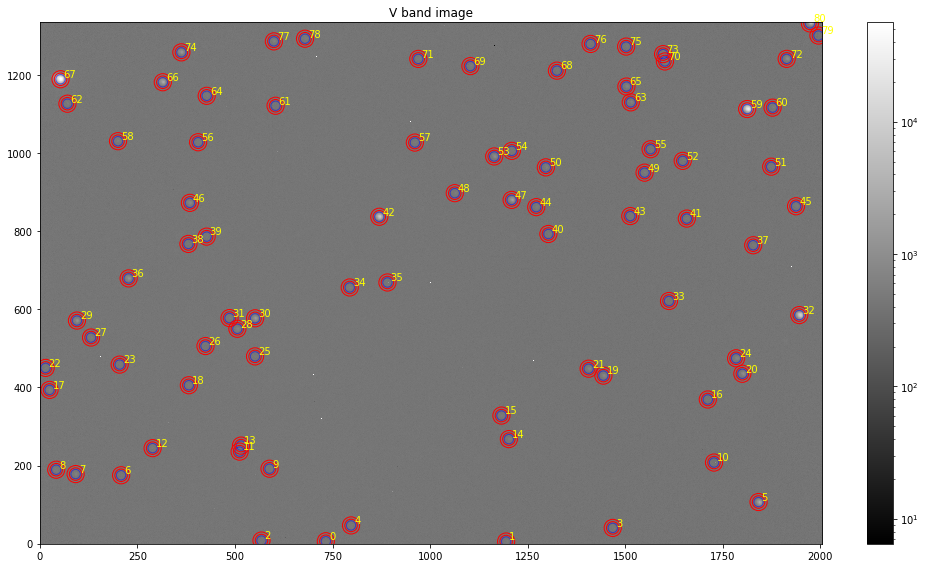

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

im = ax.imshow(data, cmap='gray', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
annulus_apertures.plot(color='red', lw=1)

#ax.set_xlim([0,1000])
#ax.set_ylim([500,1250])

for i,p in enumerate(positions):
    ax.text(p[0]+8,p[1]+5,i, color="yellow")

fig.colorbar(im, ax=ax, pad=0.04)

t = ax.set_title("{} band image".format(hdr['filter']))

In [55]:
positions_B = np.transpose((sources_B['xcentroid'], sources_B['ycentroid']))
apertures_B = CircularAperture(positions_B, r=12.)

annulus_apertures_B = CircularAnnulus(positions_B, r_in=16, r_out=22)
annulus_masks_B = annulus_apertures.to_mask(method='center')

norm_B = ImageNormalize(interval=AsymmetricPercentileInterval(0,85), stretch=LinearStretch(),clip=True)

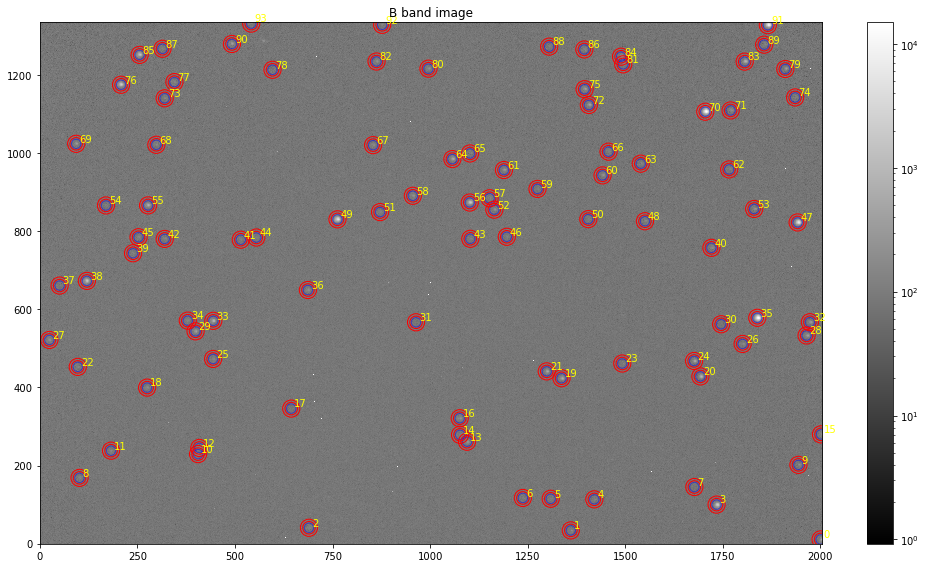

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

im = ax.imshow(data_B, cmap='gray', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures_B.plot(color='blue', lw=1, alpha=0.5)
annulus_apertures_B.plot(color='red', lw=1)

#ax.set_xlim([0,1000])
#ax.set_ylim([500,1250])

for i,p in enumerate(positions_B):
    ax.text(p[0]+8,p[1]+5,i, color="yellow")

fig.colorbar(im, ax=ax, pad=0.04)

t = ax.set_title("{} band image".format(hdr_B['filter']))

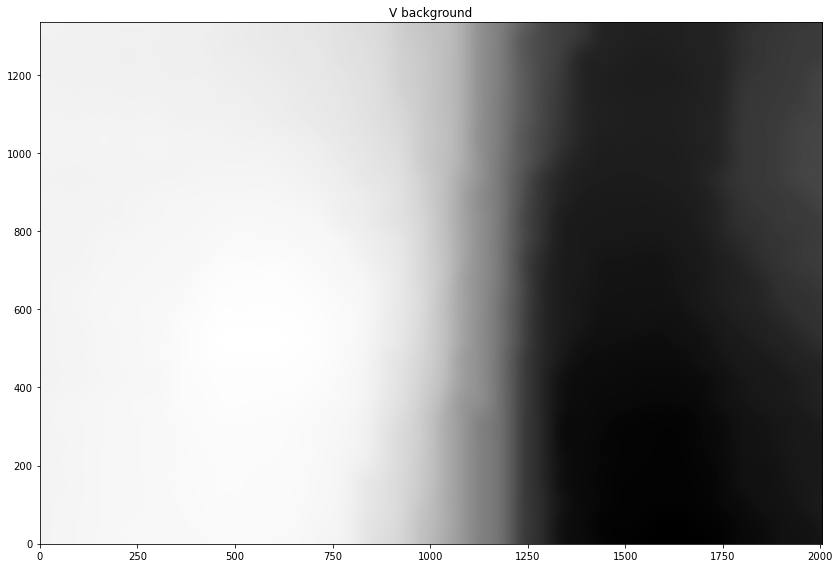

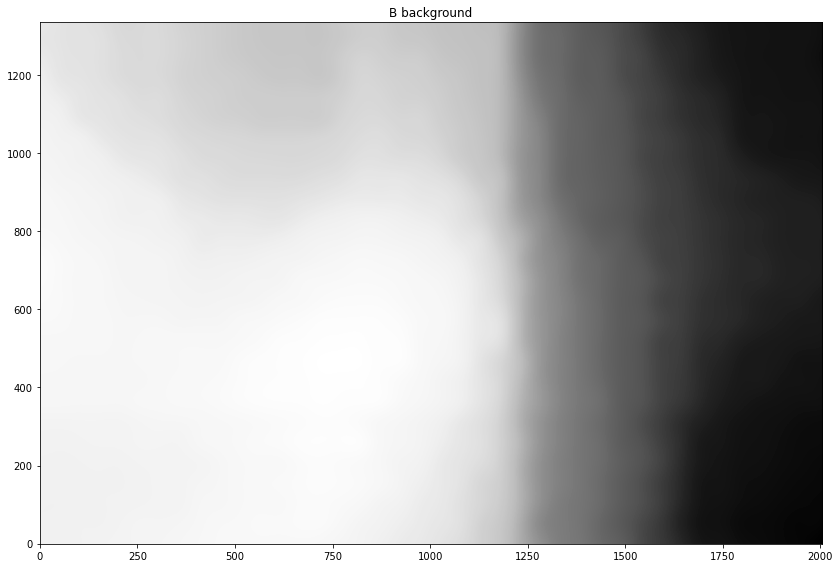

In [58]:
from photutils import Background2D, MedianBackground, SExtractorBackground
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=5.)
bkg_estimator = SExtractorBackground()
bkg = Background2D(data, (50, 50), filter_size=(12, 12),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
t = ax.set_title("V background")

ax.imshow(bkg.background, origin='lower', cmap='Greys_r', interpolation='nearest')
fig.savefig('background.png',bbox_inches="tight")

# now blue
bkg_B = Background2D(data_B, (50, 50), filter_size=(12, 12),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
t = ax.set_title("B background")
ax.imshow(bkg_B.background, origin='lower', cmap='Greys_r', interpolation='nearest')



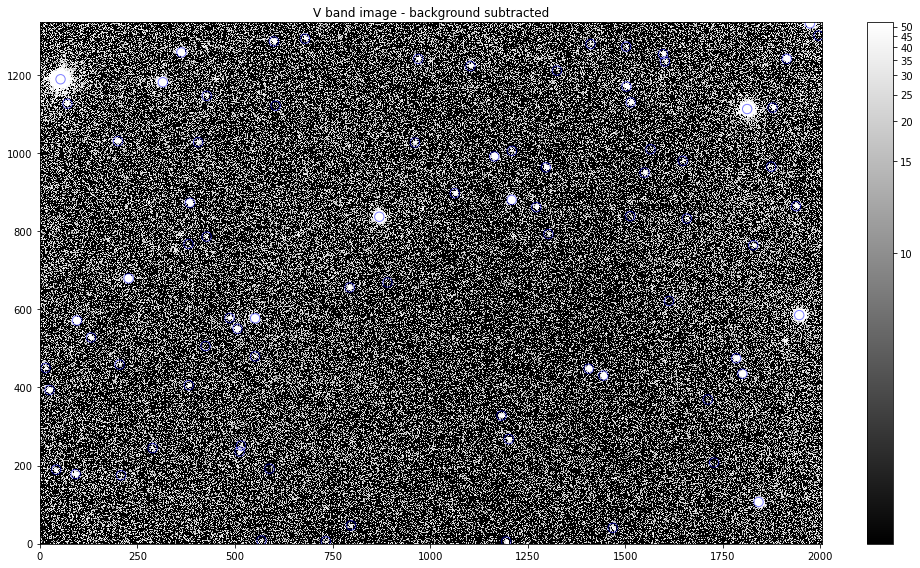

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

norm = ImageNormalize(data - bkg.background,interval=AsymmetricPercentileInterval(65,99.), stretch=LogStretch(),clip=True)

im = ax.imshow(data - bkg.background, norm=norm, origin='lower', cmap='gray', interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
fig.colorbar(im, ax=ax, pad=0.04)
t = ax.set_title("V band image - background subtracted")

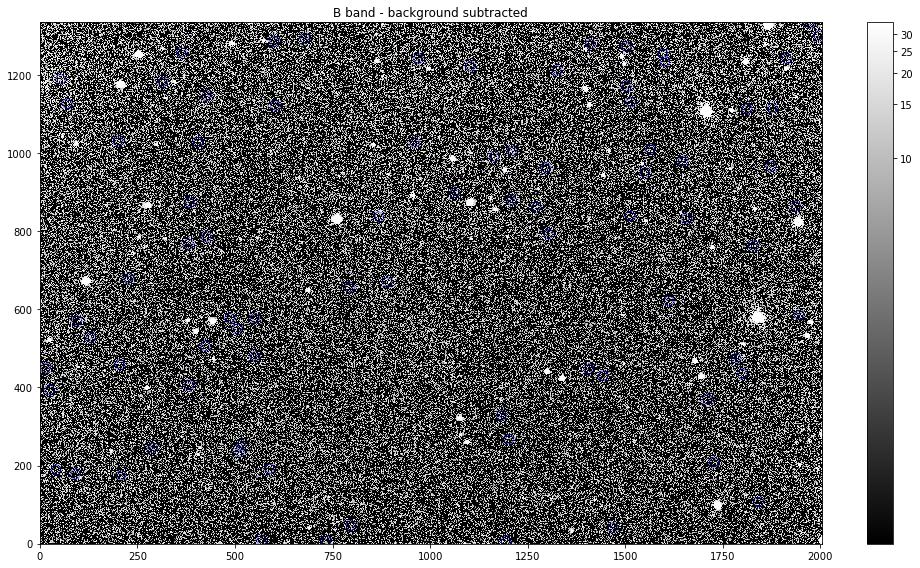

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

norm = ImageNormalize(data_B - bkg_B.background,interval=AsymmetricPercentileInterval(65,99.), stretch=LogStretch(),clip=True)

im = ax.imshow(data_B - bkg_B.background, norm=norm, origin='lower', cmap='gray', interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
fig.colorbar(im, ax=ax, pad=0.04)
t = ax.set_title("B band - background subtracted")

In [61]:
from photutils import aperture_photometry

In [62]:
apers = [apertures, annulus_apertures]
phot_table = aperture_photometry(data-bkg.background, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output

apers_B = [apertures_B, annulus_apertures_B]
phot_table_B = aperture_photometry(data_B-bkg_B.background, apers_B)
for col in phot_table_B.colnames:
    phot_table_B[col].info.format = '%.8g'  # for consistent table output

In [63]:
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 732.68763 6.0616263      2545.7592     -1029.7197
  2 1194.6819 5.3947644      7630.5576     -1096.9839
  3 567.77715 7.8187481      3207.8282     -671.19933
  4 1467.8116 40.228709      7417.5898     -729.42053
  5 797.26592 46.585285      3021.1276     -939.53163
  6 1841.4148 106.52995      210004.19      6457.5742
  7   208.072 175.10469      2560.0118      480.16021
  8 91.502475 178.15007      20408.129      937.66464
  9 41.816124 189.35472       7490.529      941.29131
 10 588.37894 191.87319      616.12454      1667.3101
...       ...       ...            ...            ...
 72 969.62384  1241.976      10620.722        -72.626
 73 1913.4683 1242.0647      46598.548       857.5177
 74  1596.825 1254.2057      11236.411      2964.7176
 75 362.56744 1258.7575      98109.802      3359.3282
 76 1502.1249 1273.5011     

In [64]:
print(phot_table_B)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 2000.3341 10.709604      21343.531     -127.44388
  2 1360.3499 33.841458      5117.7021     -234.68666
  3 689.42495 40.595737      2460.6251      -180.6657
  4  1733.875 99.902598      103892.74      1115.5458
  5 1420.6585 113.36051      1908.5743      650.74522
  6 1308.8502 114.84202      1591.2369      349.99605
  7 1237.5405 116.96226      2258.9331      256.48069
  8 1676.9078 144.96036      1079.3594      684.21672
  9 101.55368 168.44639      2192.0803     -391.90826
 10 1943.5777 201.73011      5115.1112     -15.686882
...       ...       ...            ...            ...
 85 1489.0769 1247.6091      7426.5526      3137.3545
 86 255.52412 1252.2133      61709.219      803.99475
 87 1395.0248 1266.1533      3058.4873      430.02605
 88 314.13498  1267.903      2118.0578     -700.92855
 89 1304.9932 1273.4102     

In [65]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area
bkg_mean_B = phot_table_B['aperture_sum_1'] / annulus_apertures_B.area

In [30]:
# V
bkg_sum = bkg_mean * apertures.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum

phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table['instrument_mag'] = -2.5 * np.log10(phot_table['residual_aperture_sum'] / hdr['exptime'])

print(phot_table['residual_aperture_sum','instrument_mag'])

residual_aperture_sum instrument_mag
--------------------- --------------
            3196.1085     -5.5089788
            8323.3895     -6.5481756
            3631.7435     -5.6477129
            7878.2765     -6.4885031
             3614.516     -5.6425504
            205925.72     -10.031701
            2256.7528      -5.131135
             19815.92     -7.4899606
            6896.0292     -6.3439227
            -436.9134            nan
                  ...            ...
            2344.0307     -5.1723332
            10666.591     -6.8174892
            46056.958     -8.4056631
            9363.9574     -6.6760736
            95988.121     -9.2029687
             4069.468     -5.7712691
            3248.0221     -5.5264724
            17843.984     -7.3761545
            10543.761     -6.8049139
           -1496.2834            nan
            297236.96     -10.430182
Length = 81 rows


<ipython-input-30-761bec9c4747>:7: RuntimeWarning: invalid value encountered in log10
  phot_table['instrument_mag'] = -2.5 * np.log10(phot_table['residual_aperture_sum'] / hdr['exptime'])


In [66]:
# B
bkg_sum_B = bkg_mean_B * apertures_B.area
final_sum_B = phot_table_B['aperture_sum_0'] - bkg_sum_B

phot_table_B['residual_aperture_sum'] = final_sum_B
phot_table_B['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table_B['instrument_mag'] = -2.5 * np.log10(phot_table_B['residual_aperture_sum'] / hdr_B['exptime'])

print(phot_table_B['residual_aperture_sum','instrument_mag'])

residual_aperture_sum instrument_mag
--------------------- --------------
            21424.022     -7.5746775
            5265.9253     -6.0511117
            2574.7297     -5.2742541
            103188.19        -9.2815
            1497.5773     -4.6858981
            1370.1867     -4.5893744
            2096.9453     -5.0513928
            647.22255     -3.7750591
            2439.6013     -5.2157222
            5125.0187     -6.0216636
                  ...            ...
            36192.856     -8.1439821
            5445.0656     -6.0874328
            61201.433      -8.714329
            2786.8919     -5.3602253
            2560.7495     -5.2683428
            2437.1022     -5.2146094
            3147.7051     -5.4924101
            12843.118     -7.0191012
            386576.42     -10.715513
             2060.574     -5.0323955
            2548.8714     -5.2632948
Length = 94 rows


In [43]:
# We will choose source 47 as our comparison source and look up the star and its magnitude
# on Simbad.  From there we can do relative photometry:
# m1 - m2 = -2.5 log (F_1/F_2)
# m2 & F_2 will be for our comparison star.
#
# Source 47 is Tycho 2 2832-642-1
# V = 11.77
# B = 12.27
#
ref_V = 47
F2_V = phot_table['residual_aperture_sum'][ref_V]
m2_V = 11.77

m1 = -2.5 * np.log10(phot_table['residual_aperture_sum']/F2_V) + m2_V

<ipython-input-43-2345dc4921d7>:14: RuntimeWarning: invalid value encountered in log10
  m1 = -2.5 * np.log10(phot_table['residual_aperture_sum']/F2_V) + m2_V


In [44]:
ourStar = 42
ourStarName = 'HD 16209'
ourStarLitV = 9.86

print("{} V: {:.2f} (lit V = {:.2f})".format(ourStarName,m1[ourStar],ourStarLitV))

HD 16209 V: 9.97 (lit V = 9.86)


# Now the B magnitude

In [67]:
ourStar_B = 49
ourStarLitB = 11.31

In [69]:
ref_B = 56
F2_B = phot_table_B['residual_aperture_sum'][ref_B]
m2_B = 12.27

m1_B = -2.5 * np.log10(phot_table_B['residual_aperture_sum']/F2_B) + m2_B

In [71]:

print("{} B: {:.2f} (lit B = {:.2f})".format(ourStarName,m1_B[ourStar_B],ourStarLitB))

HD 16209 B: 11.20 (lit B = 11.31)
